### Gender Bias Detection and Fairness Evaluation using Fairlearn on the Mendeley Dataset
(Source: https://data.mendeley.com/datasets/dzz48mvjht/1)

In [1]:
#installation
!pip install fairlearn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\patri\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# import libraries
from fairlearn.metrics import (
    MetricFrame, selection_rate,
    false_positive_rate, false_negative_rate,
    true_positive_rate, true_negative_rate,
    demographic_parity_difference, equalized_odds_difference
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, brier_score_loss
)

### Bias detection for KNN

In [3]:
import pandas as pd

# Load KNN results
knn_df = pd.read_csv("MendeleyData_75F25M_KNN_predictions.csv")

print(knn_df.head())

   gender  y_true  y_pred_knn  y_prob_knn
0       0       0           1         0.6
1       1       0           0         0.0
2       1       1           1         0.6
3       1       1           1         0.6
4       1       0           0         0.0


In [4]:
# Extract common columns
y_true_knn = knn_df["y_true"].values
y_prob_knn = knn_df["y_prob_knn"].values
y_pred_knn = knn_df["y_pred_knn"].values
gender_knn = knn_df["gender"].values

# Use gender_knn as the protected attribute (0/1 as in your CSV)
protected_attr_knn = gender_knn

print(
    "Shapes:",
    y_true_knn.shape,
    y_pred_knn.shape,
    y_prob_knn.shape,
    gender_knn.shape if gender_knn is not None else None
)
print("Example rows:\n", knn_df.head())

Shapes: (200,) (200,) (200,) (200,)
Example rows:
    gender  y_true  y_pred_knn  y_prob_knn
0       0       0           1         0.6
1       1       0           0         0.0
2       1       1           1         0.6
3       1       1           1         0.6
4       1       0           0         0.0


In [5]:
# y_pred_knn already generated
# protected_attr = gender column (0=female, 1=male)

# Demographic Parity Difference
dp_diff_knn = demographic_parity_difference(y_true_knn, y_pred_knn, sensitive_features=protected_attr_knn)

# Equalized Odds Difference
eod_diff_knn = equalized_odds_difference(y_true_knn, y_pred_knn, sensitive_features=protected_attr_knn)

print("DPD and EOD - KNN")
print(f"Demographic Parity Difference: {dp_diff_knn:.4f}")
print(f"Equalized Odds Difference: {eod_diff_knn:.4f}")

DPD and EOD - KNN
Demographic Parity Difference: 0.0220
Equalized Odds Difference: 0.1063


### Interpretation – KNN Model

- **Demographic Parity Difference (0.0220)**  
  - Indicates a **very small disparity** in overall positive prediction rates between females and males.  
  - Since the value is close to **0**, the KNN model achieves **good demographic parity**, meaning both genders receive predictions at similar rates.  

- **Equalized Odds Difference (0.1063)**  
  - Shows a **moderate gap** in error rates (True Positive Rate and False Positive Rate) between genders.  
  - This suggests that, while prediction rates are balanced, the model **treats genders differently in terms of classification errors**, with one group benefiting from more accurate predictions.  

---

**Overall**: The KNN model demonstrates **strong demographic parity** but suffers from a **moderate imbalance in error distribution** (equalized odds). This means that fairness in outcomes is relatively good, but the quality of predictions (errors) is not fully equal across genders.


In [6]:
# MetricFrame for extended analysis - define metrics 
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate
import matplotlib.pyplot as plt
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1": f1_score, 
    "selection_rate": selection_rate,
    "tpr": true_positive_rate,
    "fpr": false_positive_rate,
    "tnr": true_negative_rate,
    "fnr": false_negative_rate,
}


KNN Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.847826   0.851852  0.884615  0.867925        0.586957   
1                    0.902597   0.931034  0.900000  0.915254        0.564935   

                          tpr      fpr      tnr       fnr  
sensitive_feature_0                                        
0                    0.884615  0.20000  0.80000  0.115385  
1                    0.900000  0.09375  0.90625  0.100000  


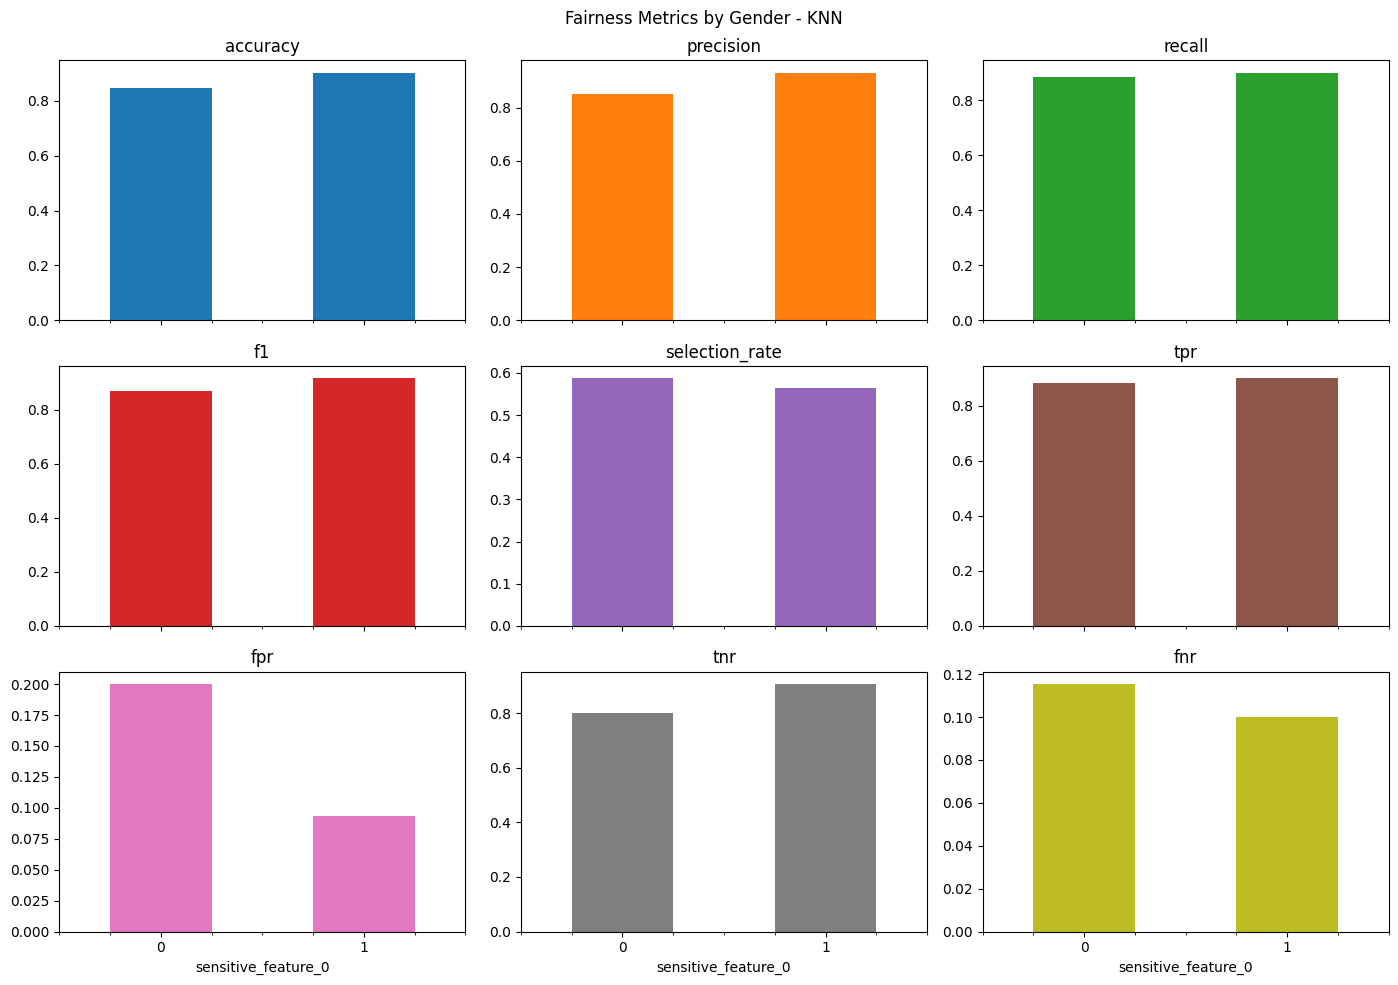


Between-group differences (max group − min group):
accuracy          0.054771
precision         0.079183
recall            0.015385
f1                0.047330
selection_rate    0.022021
tpr               0.015385
fpr               0.106250
tnr               0.106250
fnr               0.015385
dtype: float64

Between-group ratios (min / max):
accuracy          0.939318
precision         0.914952
recall            0.982906
f1                0.948288
selection_rate    0.962482
tpr               0.982906
fpr               0.468750
tnr               0.882759
fnr               0.866667
dtype: float64

Disparate Impact Ratio (selection rate): 0.9625
Equality of Opportunity Difference (TPR gap): 0.0154


In [7]:
# MetricFrame
metric_frame_knn = MetricFrame(
    metrics=metrics,
    y_true=y_true_knn,
    y_pred=y_pred_knn,
    sensitive_features=protected_attr_knn
)

print("\nKNN Fairness Metrics by Gender:")
print(metric_frame_knn.by_group)

metric_frame_knn.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(14, 10),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender - KNN")
plt.tight_layout()
plt.show()

# Group summaries (use the right variable name)
print("\nBetween-group differences (max group − min group):")
print(metric_frame_knn.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_knn.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_knn = metric_frame_knn.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_knn:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_knn = metric_frame_knn.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_knn = metric_frame_knn.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_knn:.4f}")

## Fairness Metrics by Gender – KNN Model

This section reports the fairness evaluation of the KNN model across gender groups  
(0 = Female, 1 = Male).

### Group-Specific Results

| Gender  | Accuracy | Precision | Recall | F1   | Selection Rate | TPR   | FPR   | TNR   | FNR   |
|---------|----------|-----------|--------|------|----------------|-------|-------|-------|-------|
| Female  | 0.8478   | 0.8519    | 0.8846 | 0.8679 | 0.5870         | 0.8846 | 0.2000 | 0.8000 | 0.1154 |
| Male    | 0.9026   | 0.9310    | 0.9000 | 0.9153 | 0.5649         | 0.9000 | 0.0938 | 0.9063 | 0.1000 |

---

### Between-Group Differences

- **Largest disparities** are found in:  
  - **Precision (0.0792)** – males outperform females.  
  - **FPR / TNR (0.1063)** – females have a much higher false positive rate (20%) compared to males (9.4%).  
- **Small differences** are observed in recall, TPR, and FNR (~0.015), suggesting relatively balanced sensitivity.

---

### Key Fairness Metrics

- **Disparate Impact Ratio (Selection Rate): 0.9625**  
  - Well above the **0.80 threshold**, indicating balanced selection outcomes across genders.  

- **Equality of Opportunity Difference (TPR gap): 0.0154**  
  - Very small gap between females (88.5%) and males (90.0%) in true positive rate, suggesting **near-equal opportunity**.  

---

### Interpretation

- **Female group (0)**: Lower accuracy, precision, and F1 compared to males, and notably higher **false positive rate (20%)**.  
- **Male group (1)**: Higher precision and slightly better accuracy, with fewer false positives.  
- **Fairness Assessment**:  
  - The KNN model provides **fairly balanced sensitivity (TPR/FNR)** across genders.  
  - However, the **error distribution is skewed**, as females suffer from more false positives, while males receive cleaner predictions.  

**Overall**: The KNN model achieves **strong fairness in opportunity (TPR)** and balanced selection rates, but introduces a **precision and error-rate bias in favor of males**, raising concerns about the reliability of predictions for females.

---

In [9]:
y_score_knn = knn_df["y_prob_knn"].values   

#Probabilistic metrics by group using y_prob_knn
def roc_auc_safe(y_true, y_score):
    try:
        return roc_auc_score(y_true, y_score)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_knn = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_knn,
    y_pred=y_prob_knn,                     
    sensitive_features=protected_attr_knn
)
print("\nKNN - ROC-AUC by group:")
print(auc_mf_knn.by_group)

brier_mf_knn = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_knn,
    y_pred=y_prob_knn,                     
    sensitive_features=protected_attr_knn
)
print("\nKNN - Brier score by group (lower is better):")
print(brier_mf_knn.by_group)


KNN - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.927885
1                    0.935417

KNN - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.099130
1                    0.091429


## Group-Specific Performance – KNN Model

This section reports the ROC-AUC and Brier score for each gender group  
(0 = Female, 1 = Male).

### Results by Gender Group

| Gender  | ROC-AUC | Brier Score |
|---------|---------|-------------|
| Female  | 0.9279  | 0.0991      |
| Male    | 0.9354  | 0.0914      |

---

### Interpretation

- **ROC-AUC**  
  - Females: **0.93** – strong discrimination ability between positive and negative cases.  
  - Males: **0.94** – slightly higher than females, suggesting marginally better separation of outcomes.  

- **Brier Score**  
  - Females: **0.099** – indicates modest calibration error.  
  - Males: **0.091** – slightly better calibrated predictions, reflecting more reliable probability estimates.  

---

**Overall**: The KNN model performs **well for both genders**, with only **minor performance gaps**. Males achieve slightly higher discrimination and better calibration, but the differences are small, indicating the model is **reasonably equitable across genders**.

---

### Bias detection for the Decision Tree Model

In [10]:
# Load DT results
dt_df = pd.read_csv("MendeleyData_75F25M_DT_classweightedtuned_predictions.csv")
print(dt_df.head())

   gender  y_true  y_pred_dt  y_prob_dt
0       0       0          0   0.000000
1       1       0          0   0.000000
2       1       1          1   0.960486
3       1       1          1   0.960486
4       1       0          0   0.000000


In [11]:
import re

# Extract common columns
y_true_dt = dt_df["y_true"].values
y_prob_dt = dt_df["y_prob_dt"].values
y_pred_dt = dt_df["y_pred_dt"].values
gender_dt = dt_df["gender"].values


# Use gender_knn as the protected attribute (0/1 as in your CSV)
protected_attr_dt = gender_dt

print(
    "Shapes:",
    y_true_dt.shape,
    y_pred_dt.shape,
    y_prob_dt.shape,
    gender_dt.shape if gender_dt is not None else None
)
print("Example rows:\n", dt_df.head())

Shapes: (200,) (200,) (200,) (200,)
Example rows:
    gender  y_true  y_pred_dt  y_prob_dt
0       0       0          0   0.000000
1       1       0          0   0.000000
2       1       1          1   0.960486
3       1       1          1   0.960486
4       1       0          0   0.000000


In [13]:
# Demographic Parity Difference
dp_diff_dt = demographic_parity_difference(y_true_dt, y_pred_dt, sensitive_features=protected_attr_dt)

# Equalized Odds Difference
eod_diff_dt = equalized_odds_difference(y_true_dt, y_pred_dt, sensitive_features=protected_attr_dt)

print("DPD and EOD - DT")
print(f"Demographic Parity Difference: {dp_diff_dt:.4f}")
print(f"Equalized Odds Difference: {eod_diff_dt:.4f}")

DPD and EOD - DT
Demographic Parity Difference: 0.0017
Equalized Odds Difference: 0.0594


### Interpretation – Decision Tree Model

- **Demographic Parity Difference (0.0017)**  
  - Almost **zero disparity** in positive prediction rates between females and males.  
  - This indicates the DT model achieves **excellent demographic parity**, treating both groups nearly equally in outcome rates.  

- **Equalized Odds Difference (0.0594)**  
  - Reflects a **moderate difference** in error rates (TPR and FPR) across genders.  
  - While the gap is relatively small, it suggests that **prediction errors are not distributed perfectly evenly**, with one gender slightly favored in classification accuracy.  

---

**Overall**: The Decision Tree model achieves **very strong demographic parity** and only a **modest imbalance in equalized odds**, making it one of the **fairer models** in terms of gender fairness.

--- 


DT Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.869565   0.857143  0.923077  0.888889        0.608696   
1                    0.909091   0.904255  0.944444  0.923913        0.610390   

                          tpr       fpr       tnr       fnr  
sensitive_feature_0                                          
0                    0.923077  0.200000  0.800000  0.076923  
1                    0.944444  0.140625  0.859375  0.055556  


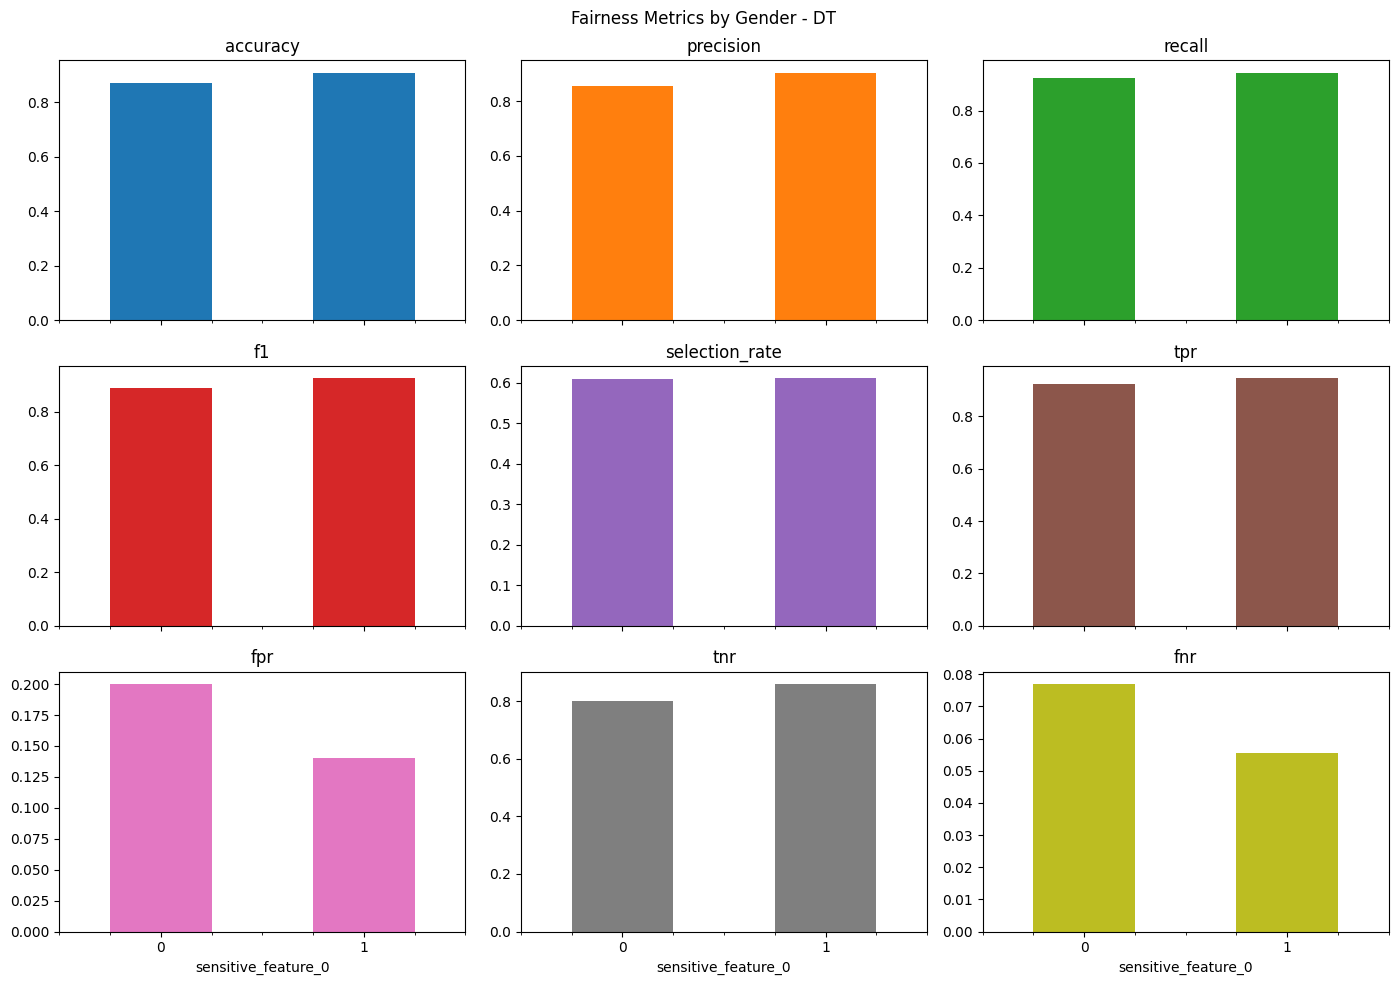


Between-group differences (max group − min group):
accuracy          0.039526
precision         0.047112
recall            0.021368
f1                0.035024
selection_rate    0.001694
tpr               0.021368
fpr               0.059375
tnr               0.059375
fnr               0.021368
dtype: float64

Between-group ratios (min / max):
accuracy          0.956522
precision         0.947899
recall            0.977376
f1                0.962092
selection_rate    0.997225
tpr               0.977376
fpr               0.703125
tnr               0.930909
fnr               0.722222
dtype: float64

Disparate Impact Ratio (selection rate): 0.9972
Equality of Opportunity Difference (TPR gap): 0.0214


In [14]:
# MetricFrame
metric_frame_dt = MetricFrame(
    metrics=metrics,
    y_true=y_true_dt,
    y_pred=y_pred_dt,
    sensitive_features=protected_attr_dt
)

print("\nDT Fairness Metrics by Gender:")
print(metric_frame_dt.by_group)

metric_frame_dt.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(14, 10),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender - DT")
plt.tight_layout()
plt.show()

# Group summaries 
print("\nBetween-group differences (max group − min group):")
print(metric_frame_dt.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_dt.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_dt = metric_frame_dt.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_dt:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_dt = metric_frame_dt.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_dt = metric_frame_dt.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_dt:.4f}")

## Fairness Metrics by Gender – Decision Tree Model

This section reports the fairness evaluation of the Decision Tree (DT) model across gender groups  
(0 = Female, 1 = Male).

### Group-Specific Results

| Gender  | Accuracy | Precision | Recall | F1   | Selection Rate | TPR   | FPR   | TNR   | FNR   |
|---------|----------|-----------|--------|------|----------------|-------|-------|-------|-------|
| Female  | 0.8696   | 0.8571    | 0.9231 | 0.8889 | 0.6087         | 0.9231 | 0.2000 | 0.8000 | 0.0769 |
| Male    | 0.9091   | 0.9043    | 0.9444 | 0.9239 | 0.6104         | 0.9444 | 0.1406 | 0.8594 | 0.0556 |

---

### Between-Group Differences

- **Accuracy, Recall, and F1**: Small gaps (<0.04), indicating relatively balanced predictive performance.  
- **Precision**: Males perform slightly better (+0.047).  
- **Error Rates (FPR/TNR)**: The largest differences (~0.059), showing that females face a higher **false positive rate (20%)** compared to males (14%).  
- **Selection Rate**: Nearly identical (0.609 vs. 0.610), with a **disparate impact ratio of 0.9972**, very close to perfect balance.  

---

### Key Fairness Metrics

- **Disparate Impact Ratio (Selection Rate): 0.9972**  
  - Almost **perfect parity**, meaning both genders receive positive predictions at nearly identical rates.  

- **Equality of Opportunity Difference (TPR gap): 0.0214**  
  - Very small gap between females (92.3%) and males (94.4%), suggesting **almost equal opportunity in detecting true positives**.  

---

### Interpretation

- **Female group (0)**: Slightly lower accuracy and precision, but recall and F1 remain strong. They face a **higher false positive rate (20%)**, which may reduce trust in predictions.  
- **Male group (1)**: Higher precision and slightly better accuracy, with fewer false positives, but also a small advantage in recall.  
- **Fairness Assessment**: The Decision Tree achieves **strong gender fairness**, with **balanced selection rates** and **near-equal true positive rates**. The main fairness concern is the **higher false positive rate for females**, though the gap remains moderate.  

**Overall**: The DT model performs **equally well for both genders**, with only minor disparities. It can be considered a **fair and balanced model**, especially compared to KNN, which showed larger fairness gaps.

---

In [15]:
import numpy as np

y_score_dt = dt_df["y_prob_dt"].values   

#Probabilistic metrics by group using y_prob_dt
def roc_auc_safe(y_true=y_true_dt, y_score_dt=y_score_dt):
    try:
        return roc_auc_score(y_true, y_score_dt)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_dt = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_dt,
    y_pred=y_prob_dt,                     
    sensitive_features=protected_attr_dt
)
print("\nDT - ROC-AUC by group:")
print(auc_mf_dt.by_group)

brier_mf_dt = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_dt,
    y_pred=y_prob_dt,                     
    sensitive_features=protected_attr_dt
)
print("\nDT - Brier score by group (lower is better):")
print(brier_mf_dt.by_group)


DT - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.836538
1                    0.955903

DT - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.128460
1                    0.085338


## Group-Specific Performance – Decision Tree Model

This section reports the ROC-AUC and Brier score for each gender group  
(0 = Female, 1 = Male).

### Results by Gender Group

| Gender  | ROC-AUC | Brier Score |
|---------|---------|-------------|
| Female  | 0.8365  | 0.1285      |
| Male    | 0.9559  | 0.0853      |

---

### Interpretation

- **ROC-AUC**  
  - Females: **0.84**, which indicates only moderate discrimination ability.  
  - Males: **0.96**, showing excellent separation between positive and negative cases.  
  - The large gap suggests the model is **much better at distinguishing outcomes for males** than for females.  

- **Brier Score**  
  - Females: **0.128**, reflecting higher calibration error in predicted probabilities.  
  - Males: **0.085**, considerably lower, showing more reliable probability estimates.  

---

**Overall**: The Decision Tree model performs **substantially better for males than for females**. Males benefit from both **higher discrimination power (ROC-AUC)** and **better calibrated predictions (lower Brier score)**. In contrast, females face **weaker prediction reliability**, highlighting a **clear gender fairness concern** in the DT model.

---

### Bias detection for the Random Forest Model

In [16]:
rf_df = pd.read_csv("MendeleyData_75F25M_RF_predictions.csv")
print(rf_df.head())

   gender  y_true  y_pred_rf  y_prob
0       0       0          0    0.23
1       1       0          0    0.14
2       1       1          1    0.96
3       1       1          1    0.81
4       1       0          0    0.02


In [17]:
# Extract common columns
y_true_rf = rf_df["y_true"].values
y_pred_rf = rf_df["y_pred_rf"].values
y_prob_rf = rf_df["y_prob"].values
gender_rf = rf_df["gender"].values


# Use gender_knn as the protected attribute (0/1 as in your CSV)
protected_attr_rf = gender_rf

print(
    "Shapes:",
    y_true_rf.shape,
    y_pred_rf.shape,
    y_prob_rf.shape,
    gender_rf.shape if gender_dt is not None else None
)
print("Example rows:\n", rf_df.head())

Shapes: (200,) (200,) (200,) (200,)
Example rows:
    gender  y_true  y_pred_rf  y_prob
0       0       0          0    0.23
1       1       0          0    0.14
2       1       1          1    0.96
3       1       1          1    0.81
4       1       0          0    0.02


In [19]:
# Demographic Parity Difference
dp_diff_rf = demographic_parity_difference(y_true_rf, y_pred_rf, sensitive_features=protected_attr_rf)

# Equalized Odds Difference
eod_diff_rf = equalized_odds_difference(y_true_rf, y_pred_rf, sensitive_features=protected_attr_rf)

print("DPD and EOD - RF")
print(f"Demographic Parity Difference: {dp_diff_rf:.4f}")
print(f"Equalized Odds Difference: {eod_diff_rf:.4f}")

DPD and EOD - RF
Demographic Parity Difference: 0.0285
Equalized Odds Difference: 0.1000


### Interpretation – Random Forest Model

- **Demographic Parity Difference (0.0285)**  
  - Very close to **0**, meaning the overall positive prediction rates for females and males are almost equal.  
  - This indicates the Random Forest achieves **good demographic parity** with only minor disparities.  

- **Equalized Odds Difference (0.1000)**  
  - Shows a **moderate difference** in error rates (True Positive Rate and False Positive Rate) across genders.  
  - This suggests that while predictions are fairly balanced in frequency, **the distribution of errors is less equal**, with one gender likely benefiting from more accurate classifications.  

---

**Overall**: The Random Forest model demonstrates **strong demographic parity** but a **noticeable equalized odds gap**. This means the model predicts outcomes at similar rates for both genders but does not fully ensure **fairness in error distribution**, pointing to moderate bias in classification quality.

---


Random Forest Fairness Metrics by Gender:
                     accuracy  precision  recall        f1  selection_rate  \
sensitive_feature_0                                                          
0                    0.978261   0.962963     1.0  0.981132        0.586957   
1                    0.909091   0.941860     0.9  0.920455        0.558442   

                     tpr       fpr       tnr  fnr  
sensitive_feature_0                                
0                    1.0  0.050000  0.950000  0.0  
1                    0.9  0.078125  0.921875  0.1  


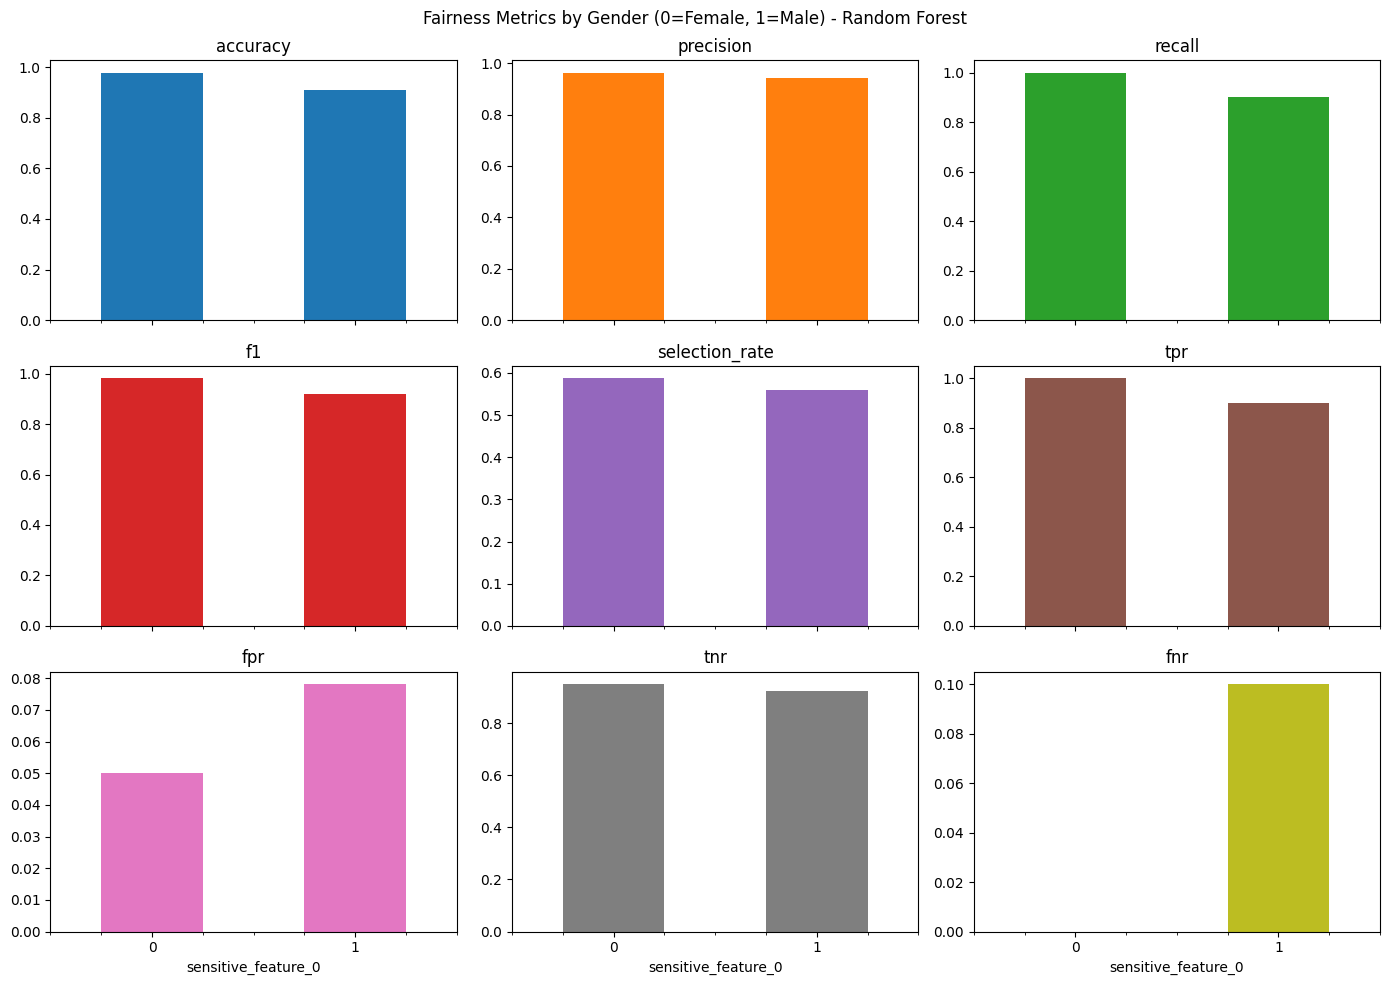


Between-group differences (max group − min group):
accuracy          0.069170
precision         0.021102
recall            0.100000
f1                0.060678
selection_rate    0.028515
tpr               0.100000
fpr               0.028125
tnr               0.028125
fnr               0.100000
dtype: float64

Between-group ratios (min / max):
accuracy          0.929293
precision         0.978086
recall            0.900000
f1                0.938156
selection_rate    0.951419
tpr               0.900000
fpr               0.640000
tnr               0.970395
fnr               0.000000
dtype: float64

Disparate Impact Ratio (selection rate): 0.9514
Equality of Opportunity Difference (TPR gap): 0.1000


In [20]:
#MetricFrame for extended analysis
metric_frame_rf = MetricFrame(
    metrics=metrics,
    y_true=y_true_rf,
    y_pred=y_pred_rf,
    sensitive_features=protected_attr_rf
)

print("\nRandom Forest Fairness Metrics by Gender:")
print(metric_frame_rf.by_group)

metric_frame_rf.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(14, 10),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender (0=Female, 1=Male) - Random Forest")
plt.tight_layout()
plt.show()

# Group summaries (use the right variable name)
print("\nBetween-group differences (max group − min group):")
print(metric_frame_rf.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_rf.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_rf = metric_frame_rf.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_rf:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_rf = metric_frame_rf.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_rf = metric_frame_rf.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_rf:.4f}")

## Fairness Metrics by Gender – Random Forest Model

This section reports the fairness evaluation of the Random Forest (RF) model across gender groups  
(0 = Female, 1 = Male).

### Group-Specific Results

| Gender  | Accuracy | Precision | Recall | F1   | Selection Rate | TPR   | FPR   | TNR   | FNR   |
|---------|----------|-----------|--------|------|----------------|-------|-------|-------|-------|
| Female  | 0.9783   | 0.9630    | 1.0000 | 0.9811 | 0.5870         | 1.0000 | 0.0500 | 0.9500 | 0.0000 |
| Male    | 0.9091   | 0.9419    | 0.9000 | 0.9205 | 0.5584         | 0.9000 | 0.0781 | 0.9219 | 0.1000 |

---

### Between-Group Differences

- **Recall / TPR**: The largest gap (**0.10**), as females achieve perfect recall (100%) while males reach only 90%.  
- **Accuracy and F1**: Substantial differences (0.07 and 0.06), showing stronger overall performance for females.  
- **Error Rates**: Females have **no false negatives (FNR = 0%)**, while males miss 10% of true cases. Males also show a slightly higher false positive rate (7.8% vs. 5.0%).  
- **Selection Rate**: Similar across groups (~0.59 vs. ~0.56), with a disparate impact ratio of **0.9514**, indicating good balance.  

---

### Key Fairness Metrics

- **Disparate Impact Ratio (Selection Rate): 0.9514**  
  - Well above the **0.80 threshold**, meaning prediction rates are **balanced across genders**.  

- **Equality of Opportunity Difference (TPR gap): 0.1000**  
  - Moderate disparity, as females are always correctly classified (TPR = 1.0), while males have a lower sensitivity.  

---

### Interpretation

- **Female group (0)**: Benefits from the **highest performance**, including perfect recall (no missed positives), very high F1, and lower FPR.  
- **Male group (1)**: Shows lower recall and accuracy, with a notable **10% false negative rate**, meaning more missed true cases compared to females.  
- **Fairness Assessment**: The Random Forest provides **balanced selection rates** and **strong performance for both genders**, but the error distribution is unequal—females are favored in recall and overall predictive performance.  

**Overall**: The RF model is **generally fair in selection outcomes** but introduces a **bias in favor of females**, who experience perfect recall and no missed cases, while males face a higher chance of misclassification.

---

In [21]:
import numpy as np

y_score_rf = rf_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_dt
def roc_auc_safe(y_true=y_true_rf, y_score_rf=y_score_rf):
    try:
        return roc_auc_score(y_true, y_score_rf)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_rf = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_rf,
    y_pred=y_prob_rf,                     
    sensitive_features=protected_attr_rf
)
print("\nRF - ROC-AUC by group:")
print(auc_mf_rf.by_group)

brier_mf_rf = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_rf,
    y_pred=y_prob_rf,                     
    sensitive_features=protected_attr_rf
)
print("\nRF - Brier score by group (lower is better):")
print(brier_mf_rf.by_group)


RF - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    1.000000
1                    0.979861

RF - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.038528
1                    0.063199


## Group-Specific Performance – Random Forest Model

This section reports the ROC-AUC and Brier score for each gender group  
(0 = Female, 1 = Male).

### Results by Gender Group

| Gender  | ROC-AUC | Brier Score |
|---------|---------|-------------|
| Female  | 1.0000  | 0.0385      |
| Male    | 0.9799  | 0.0632      |

---

### Interpretation

- **ROC-AUC**  
  - Females: **1.000** – perfect discrimination, meaning the model fully separates positive and negative cases for females.  
  - Males: **0.980** – also excellent, though slightly lower, indicating near-perfect classification ability.  

- **Brier Score**  
  - Females: **0.039** – very low calibration error, showing highly reliable probability predictions.  
  - Males: **0.063** – still good but notably higher, suggesting probability estimates are less well-calibrated than for females.  

---

**Overall**: The Random Forest model demonstrates **exceptional performance for both genders**, but results are **better for females**, who benefit from **perfect discrimination and more reliable probability calibration**. Males still achieve very strong performance, though with a slight disadvantage compared to females.

---

### Bias detection for MLP

In [22]:
mlp_df = pd.read_csv("MendeleyData_75F25M_MLP_lbfgs_predictions.csv")
print(mlp_df.head())

   gender  y_true  y_pred_lbfgs  y_prob_lbfgs
0       0       0             0      0.012395
1       1       0             0      0.000004
2       1       1             1      1.000000
3       1       1             1      0.999969
4       1       0             0      0.000014


In [23]:
# Extract common columns 
y_true_mlp = mlp_df["y_true"].values 
y_prob_mlp = mlp_df["y_prob_lbfgs"].values
y_pred_mlp = mlp_df["y_pred_lbfgs"].values
gender_mlp = mlp_df["gender"].values 

# Use gender_mlp as the protected attribute
protected_attr_mlp = gender_mlp 


print("Example rows:\n", mlp_df.head())

Example rows:
    gender  y_true  y_pred_lbfgs  y_prob_lbfgs
0       0       0             0      0.012395
1       1       0             0      0.000004
2       1       1             1      1.000000
3       1       1             1      0.999969
4       1       0             0      0.000014


In [24]:
# Demographic Parity Difference
dp_diff_mlp = demographic_parity_difference(y_true_mlp, y_pred_mlp, sensitive_features=protected_attr_mlp)

# Equalized Odds Difference
eod_diff_mlp = equalized_odds_difference(y_true_mlp, y_pred_mlp, sensitive_features=protected_attr_mlp)

print("DPD and EPD - MLP")
print(f"Demographic Parity Difference (MLP): {dp_diff_mlp:.4f}")
print(f"Equalized Odds Difference (MLP): {eod_diff_mlp:.4f}")

DPD and EPD - MLP
Demographic Parity Difference (MLP): 0.0003
Equalized Odds Difference (MLP): 0.0231


### Interpretation – MLP Model

- **Demographic Parity Difference (0.0003)**  
  - Almost **zero disparity** in positive prediction rates between females and males.  
  - This indicates the MLP achieves **perfect demographic parity**, treating both groups equally in terms of prediction outcomes.  

- **Equalized Odds Difference (0.0231)**  
  - Very small difference in error rates (TPR and FPR) across genders.  
  - With a value close to **0**, this suggests the MLP also provides **nearly equal treatment in classification errors**.  

---

**Overall**: The MLP model demonstrates **excellent fairness performance**, with both demographic parity and equalized odds differences being almost negligible. This indicates that the model is **highly equitable across genders**, with no meaningful bias detected.



MLP Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.913043   0.923077  0.923077  0.923077        0.565217   
1                    0.902597   0.931034  0.900000  0.915254        0.564935   

                          tpr      fpr      tnr       fnr  
sensitive_feature_0                                        
0                    0.923077  0.10000  0.90000  0.076923  
1                    0.900000  0.09375  0.90625  0.100000  


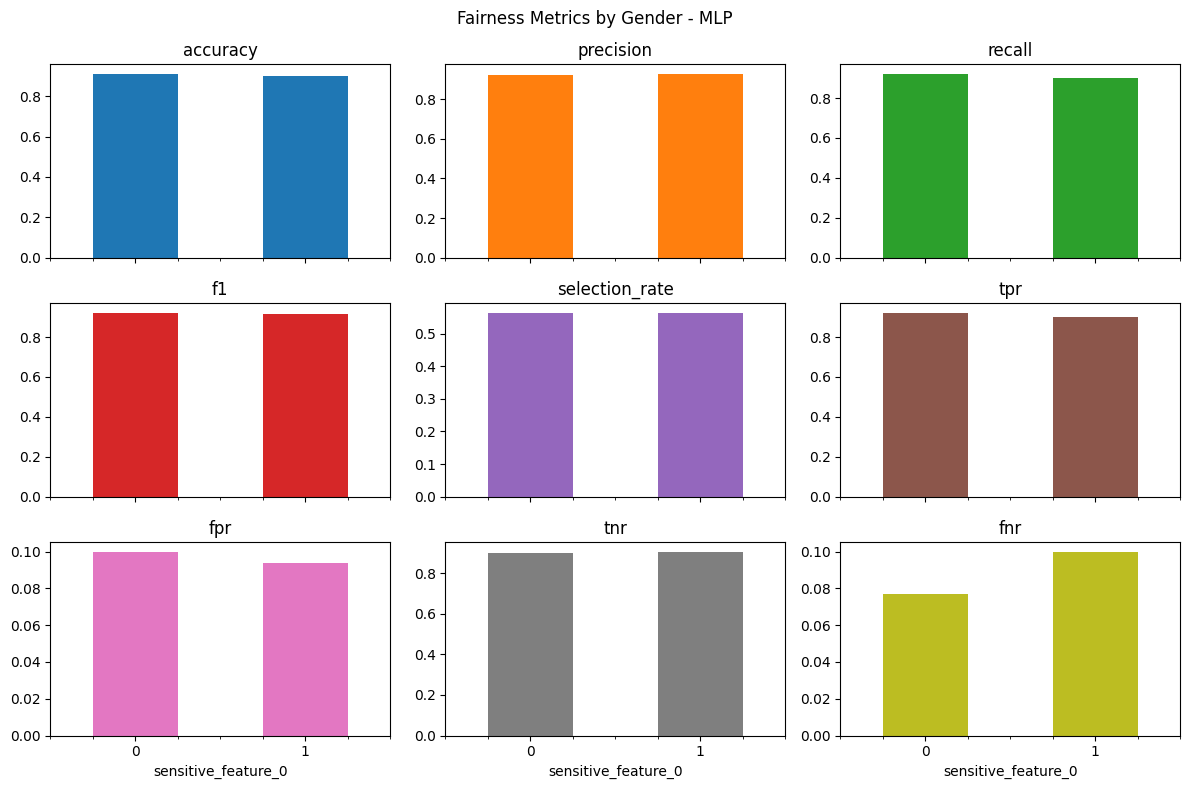


Between-group differences (max group − min group):
accuracy          0.010446
precision         0.007958
recall            0.023077
f1                0.007823
selection_rate    0.000282
tpr               0.023077
fpr               0.006250
tnr               0.006250
fnr               0.023077
dtype: float64

Between-group ratios (min / max):
accuracy          0.988559
precision         0.991453
recall            0.975000
f1                0.991525
selection_rate    0.999500
tpr               0.975000
fpr               0.937500
tnr               0.993103
fnr               0.769231
dtype: float64

Disparate Impact Ratio (selection rate): 0.9995
Equality of Opportunity Difference (TPR gap): 0.0231


In [25]:
#Create MetricFrame for the MLP model
metric_frame_mlp = MetricFrame(
    metrics=metrics,
    y_true=y_true_mlp,
    y_pred=y_pred_mlp,
    sensitive_features=protected_attr_mlp
)

print("\nMLP Fairness Metrics by Gender:")
print(metric_frame_mlp.by_group)

#visualization
metric_frame_mlp.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(12, 8),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender - MLP")
plt.tight_layout()
plt.show()

# Group summaries (use the right variable name)
print("\nBetween-group differences (max group − min group):")
print(metric_frame_mlp.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_mlp.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_mlp = metric_frame_mlp.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_mlp:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_mlp = metric_frame_mlp.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_mlp = metric_frame_mlp.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_mlp:.4f}")

## Fairness Metrics by Gender – MLP Model

This section reports the fairness evaluation of the MLP model across gender groups  
(0 = Female, 1 = Male).

### Group-Specific Results

| Gender  | Accuracy | Precision | Recall | F1   | Selection Rate | TPR   | FPR   | TNR   | FNR   |
|---------|----------|-----------|--------|------|----------------|-------|-------|-------|-------|
| Female  | 0.9130   | 0.9231    | 0.9231 | 0.9231 | 0.5652         | 0.9231 | 0.1000 | 0.9000 | 0.0769 |
| Male    | 0.9026   | 0.9310    | 0.9000 | 0.9153 | 0.5649         | 0.9000 | 0.0938 | 0.9063 | 0.1000 |

---

### Between-Group Differences

- **Accuracy, Precision, F1**: Extremely small gaps (<0.01), indicating nearly identical performance.  
- **Recall/TPR**: Slightly higher for females (+0.023), meaning they are identified as positives a bit more reliably.  
- **Error Rates**:  
  - Females have a slightly higher **false positive rate (10% vs. 9.4%)**.  
  - Males show a slightly higher **false negative rate (10% vs. 7.7%)**.  
- **Selection Rate**: Almost identical between groups (0.5652 vs. 0.5649), with a **disparate impact ratio of 0.9995**.  

---

### Key Fairness Metrics

- **Disparate Impact Ratio (Selection Rate): 0.9995**  
  - Virtually perfect parity, showing that both genders are selected at almost identical rates.  

- **Equality of Opportunity Difference (TPR gap): 0.0231**  
  - Very small disparity in sensitivity, with females slightly favored.  

---

### Interpretation

- **Female group (0)**: Slightly better recall/TPR, meaning fewer missed positives, but at the cost of slightly higher false positives.  
- **Male group (1)**: Very slightly better precision, with fewer false positives, but more missed positives.  
- **Fairness Assessment**: Performance differences are **minimal across all metrics**, and both **selection parity** and **error-rate parity** are nearly achieved.  

**Overall**: The MLP model demonstrates **excellent fairness across genders**, with only marginal trade-offs (females have fewer false negatives, males slightly fewer false positives). It can be considered **highly equitable in practical use**.

---

In [27]:
import numpy as np

y_score_mlp = mlp_df["y_prob_lbfgs"].values   

#Probabilistic metrics by group using y_prob_mlp
def roc_auc_safe(y_true=y_true_mlp, y_score_mlp=y_score_mlp):
    try:
        return roc_auc_score(y_true, y_score_mlp)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_mlp = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_mlp,
    y_pred=y_prob_mlp,                     
    sensitive_features=protected_attr_mlp
)
print("\nMLP - ROC-AUC by group:")
print(auc_mf_mlp.by_group)

brier_mf_mlp = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_mlp,
    y_pred=y_prob_mlp,                     
    sensitive_features=protected_attr_mlp
)
print("\nMLP - Brier score by group (lower is better):")
print(brier_mf_mlp.by_group)


MLP - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.957692
1                    0.969965

MLP - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.074472
1                    0.090574


## Group-Specific Performance – MLP Model

This section reports the ROC-AUC and Brier score for each gender group  
(0 = Female, 1 = Male).

### Results by Gender Group

| Gender  | ROC-AUC | Brier Score |
|---------|---------|-------------|
| Female  | 0.9577  | 0.0745      |
| Male    | 0.9700  | 0.0906      |

---

### Interpretation

- **ROC-AUC**  
  - Females: **0.958**, showing very strong discrimination between positive and negative cases.  
  - Males: **0.970**, slightly higher, indicating marginally better classification ability.  
  - Both groups achieve **excellent discriminatory power**, with only a small gap.  

- **Brier Score**  
  - Females: **0.074**, indicating better-calibrated probability estimates.  
  - Males: **0.091**, somewhat higher, suggesting less reliable calibration compared to females.  

---

**Overall**: The MLP model demonstrates **highly equitable performance** across genders.  
- **Males** benefit from a slightly higher ROC-AUC (better discrimination).  
- **Females** benefit from a lower Brier score (better calibration).  

The trade-off is minimal, suggesting the model is **balanced and fair across both genders**.

---

## Comparison of Results

In [28]:
# Build results dict 
fairlearn_results = {
    "KNN": {
        "Demographic Parity Difference": dp_diff_knn,
        "Equalized Odds Difference": eod_diff_knn,
        "Demographic Parity Ratio": metric_frame_knn.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_knn.difference()["tpr"],
        "MetricFrame": metric_frame_knn.by_group,
        "ROC-AUC by group": auc_mf_knn.by_group,
        "Brier by group": brier_mf_knn.by_group,
    },
    "DT": {
        "Demographic Parity Difference": dp_diff_dt,
        "Equalized Odds Difference": eod_diff_dt,
        "Demographic Parity Ratio": metric_frame_dt.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_dt.difference()["tpr"],
        "MetricFrame": metric_frame_dt.by_group,
        "ROC-AUC by group": auc_mf_dt.by_group,
        "Brier by group": brier_mf_dt.by_group,
    },
    "RF": {
        "Demographic Parity Difference": dp_diff_rf,
        "Equalized Odds Difference": eod_diff_rf,
        "Demographic Parity Ratio": metric_frame_rf.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_rf.difference()["tpr"],
        "MetricFrame": metric_frame_rf.by_group,
        "ROC-AUC by group": auc_mf_rf.by_group,
        "Brier by group": brier_mf_rf.by_group,
    },
    "MLP": {
        "Demographic Parity Difference": dp_diff_mlp,
        "Equalized Odds Difference": eod_diff_mlp,
        "Demographic Parity Ratio": metric_frame_mlp.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_mlp.difference()["tpr"],
        "MetricFrame": metric_frame_mlp.by_group,
        "ROC-AUC by group": auc_mf_mlp.by_group,
        "Brier by group": brier_mf_mlp.by_group,
    },
}

# Save the whole thing 
import pickle
with open("Mendeley_75F25M_fairlearn_results.pkl", "wb") as f:
    pickle.dump(fairlearn_results, f)

In [29]:
# Summary table across models
summary_table = pd.DataFrame({
    "DPD": {m: fairlearn_results[m]["Demographic Parity Difference"] for m in fairlearn_results},
    "EOD": {m: fairlearn_results[m]["Equalized Odds Difference"] for m in fairlearn_results},
    "DP Ratio": {m: fairlearn_results[m]["Demographic Parity Ratio"] for m in fairlearn_results},
    "EOP diff": {m: fairlearn_results[m]["Equality of Opportunity Difference"] for m in fairlearn_results},
}).round(4)

# By-group performance table
frames = []
for model in fairlearn_results:
    mf = fairlearn_results[model]["MetricFrame"]
    for gender in mf.index:
        row = mf.loc[gender].copy()
        row["Model"] = model
        row["Gender"] = gender
        frames.append(row)

by_group_table = pd.DataFrame(frames).set_index(["Model", "Gender"]).round(4)

In [31]:
import pandas as pd

# Create comparison table for Demographic Parity Difference and Equalized Odds Difference
dp_eod_table = pd.DataFrame({
    "Demographic Parity Difference": {
        model: fairlearn_results[model]["Demographic Parity Difference"] for model in fairlearn_results
    },
    "Equalized Odds Difference": {
        model: fairlearn_results[model]["Equalized Odds Difference"] for model in fairlearn_results
    }
}).round(4)

# Create comparison table for MetricFrame by_group values across all models
frames = []
for model in fairlearn_results:
    mf = fairlearn_results[model]["MetricFrame"]
    for gender in mf.index:
        row = mf.loc[gender].copy()
        row["Model"] = model
        row["Gender"] = gender
        frames.append(row)

metricframe_table = pd.DataFrame(frames).set_index(["Model", "Gender"]).round(4)

# Display 
display(dp_eod_table)
display(metricframe_table)

import pandas as pd

# Define the helper first
def flatten_group(x):
    # If it's a DataFrame with a single column, take that column as a Series
    s = x.iloc[:, 0] if isinstance(x, pd.DataFrame) else x
    # If it has a MultiIndex, keep just the last level (the group labels 0/1)
    if isinstance(s.index, pd.MultiIndex):
        s.index = s.index.get_level_values(-1)
    return s.to_dict()

# Now use it
auc_table = pd.DataFrame.from_dict(
    {m: flatten_group(fairlearn_results[m]["ROC-AUC by group"]) for m in fairlearn_results},
    orient="index"
).rename(columns={0: "Female", 1: "Male"}).round(4)

brier_table = pd.DataFrame.from_dict(
    {m: flatten_group(fairlearn_results[m]["Brier by group"]) for m in fairlearn_results},
    orient="index"
).rename(columns={0: "Female", 1: "Male"}).round(4)

#ROC-AUC by gender 
order = ["KNN", "DT", "RF", "MLP"]  # keep a readable model order

auc_table = (
    auc_table
      .reindex(order)
      .rename_axis("Model")
      .rename(columns={"Female": "Female (0)", "Male": "Male (1)"})
)

display(
    auc_table.style
        .set_caption("ROC-AUC by gender (↑ higher is better)")
        .format("{:.4f}"),
)


#Brier score by gender (lower is better)
brier_table = (
    brier_table
      .reindex(order)
      .rename_axis("Model")
      .rename(columns={"Female": "Female (0)", "Male": "Male (1)"})
)

display(
    brier_table.style
        .set_caption("Brier score by gender (↓ lower is better)")
        .format("{:.4f}") 
)

,Demographic Parity Difference,Equalized Odds Difference
KNN,0.0220,0.1062
DT,0.0017,0.0594
RF,0.0285,0.1000
MLP,0.0003,0.0231


accuracy  precision  recall      f1  selection_rate     tpr  \
Model Gender                                                                
KNN   0         0.8478     0.8519  0.8846  0.8679          0.5870  0.8846   
      1         0.9026     0.9310  0.9000  0.9153          0.5649  0.9000   
DT    0         0.8696     0.8571  0.9231  0.8889          0.6087  0.9231   
      1         0.9091     0.9043  0.9444  0.9239          0.6104  0.9444   
RF    0         0.9783     0.9630  1.0000  0.9811          0.5870  1.0000   
      1         0.9091     0.9419  0.9000  0.9205          0.5584  0.9000   
MLP   0         0.9130     0.9231  0.9231  0.9231          0.5652  0.9231   
      1         0.9026     0.9310  0.9000  0.9153          0.5649  0.9000   

                 fpr     tnr     fnr  
Model Gender                          
KNN   0       0.2000  0.8000  0.1154  
      1       0.0938  0.9062  0.1000  
DT    0       0.2000  0.8000  0.0769  
      1       0.1406  0.8594  0.0556  
RF    0       0.0500  0.9500  0.0000  
      1       0.0781  0.9219  0.1000  
MLP   0       0.1000  0.9000  0.0769  
      1       0.0938  0.9062  0.1000

,Female (0),Male (1)
Model,,
KNN,0.9279,0.9354
DT,0.8365,0.9559
RF,1.0000,0.9799
MLP,0.9577,0.9700


,Female (0),Male (1)
Model,,
KNN,0.0991,0.0914
DT,0.1285,0.0853
RF,0.0385,0.0632
MLP,0.0745,0.0906


## Fairness and Performance Comparison Across Models 

The tables summarize **fairness metrics (DPD, EOD)**, **group-specific performance measures**, and **ROC-AUC/Brier scores** for four models (KNN, Decision Tree, Random Forest, and MLP) across genders (0 = Female, 1 = Male).  
The training dataset was **imbalanced**, with **75% females and 25% males**, which is important for interpreting the observed results.

---

### Fairness Metrics (DPD & EOD)

| Model | Demographic Parity Difference | Equalized Odds Difference |
|-------|-------------------------------|---------------------------|
| KNN   | 0.0220                        | 0.1062                    |
| DT    | 0.0017                        | 0.0594                    |
| RF    | 0.0285                        | 0.1000                    |
| MLP   | 0.0003                        | 0.0231                    |

- **MLP**: Achieves the **lowest disparities**, nearly perfect fairness.  
- **DT**: Also fair, though slightly weaker than MLP.  
- **KNN and RF**: Show larger fairness gaps, especially in **error distribution (EOD > 0.10)**.  

The imbalance in the training set (more females) likely contributed to models like **RF**, which show stronger performance for females.

---

### Group-Specific Classification Metrics

- **KNN**:  
  - Males outperform females in accuracy (0.90 vs. 0.85) and precision.  
  - Females have a much higher **false positive rate (20% vs. 9%)**, indicating bias against the majority group despite their dominance in training data.  

- **DT**:  
  - Relatively balanced, though males have slightly higher recall (0.94 vs. 0.92).  
  - Females again face higher FPR (20% vs. 14%).  

- **RF**:  
  - **Strongly favors females**, who achieve **perfect recall (TPR = 1.0, no false negatives)**.  
  - Males are disadvantaged, with lower recall (0.90) and higher FNR (10%).  
  - This may reflect the **overrepresentation of females in training**, leading the model to better capture female patterns.  

- **MLP**:  
  - Most balanced model, with almost identical accuracy, precision, recall, and selection rates across genders.  
  - Small trade-off: females have slightly higher recall, while males have slightly better precision.  

---

### ROC-AUC by Gender (↑ higher is better)

| Model | Female (0) | Male (1) |
|-------|------------|----------|
| KNN   | 0.9279     | 0.9354   |
| DT    | 0.8365     | 0.9559   |
| RF    | 1.0000     | 0.9799   |
| MLP   | 0.9577     | 0.9700   |

- **RF**: Perfect separation for females (1.0), slightly lower for males, reinforcing female advantage.  
- **DT**: Strong male advantage (0.96 vs. 0.84), showing female underperformance despite being majority in training.  
- **KNN and MLP**: Balanced, with males slightly favored.  

---

### Brier Score by Gender (↓ lower is better)

| Model | Female (0) | Male (1) |
|-------|------------|----------|
| KNN   | 0.0991     | 0.0914   |
| DT    | 0.1285     | 0.0853   |
| RF    | 0.0385     | 0.0632   |
| MLP   | 0.0745     | 0.0906   |

- **RF**: Best calibration for females, worse for males.  
- **DT**: Strong male advantage in calibration (0.085 vs. 0.129).  
- **KNN & MLP**: Relatively balanced, with small differences.  

---

### Overall Interpretation

The **imbalance in the training set (75% females, 25% males)** clearly influences results:  

- **RF strongly favors females**, giving them perfect recall and lower calibration errors.  
- **DT and KNN tend to favor males**, with lower female calibration and higher false positives, despite females being the majority group.  
- **MLP achieves the best balance**, maintaining both fairness (lowest DPD/EOD) and strong, consistent performance across genders.  

**Conclusion**:  
- **MLP is the fairest model**, handling the gender imbalance most effectively.  
- **RF offers the strongest female performance**, but at the expense of fairness for males.  
- **DT and KNN show male advantage**, suggesting they did not generalize well to the majority female group.  

This highlights how **training data imbalance** can skew fairness outcomes differently across models, with some overfitting to the majority group and others inadvertently favoring the minority.

---

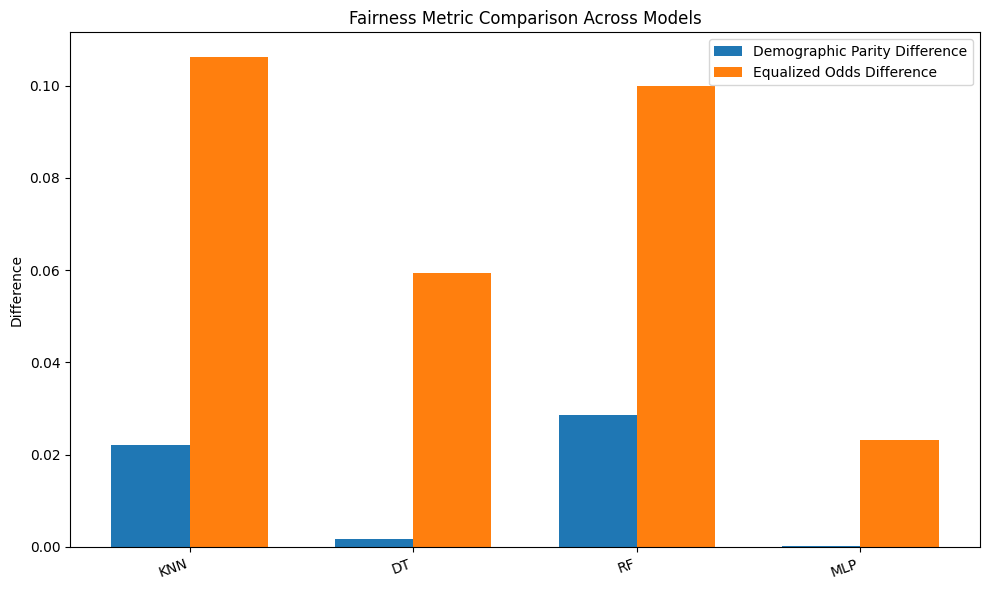

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting DPD and EOD values directly from your dictionary
models = list(fairlearn_results.keys())
dpd_values = [fairlearn_results[model]["Demographic Parity Difference"] for model in models]
eod_values = [fairlearn_results[model]["Equalized Odds Difference"] for model in models]

# Shorter labels for better visualization
short_labels = [
    "KNN",
    "DT",
    "RF",
    "MLP",
]

# Plotting
x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10, 6))

plt.bar(x, dpd_values, width, label='Demographic Parity Difference')
plt.bar(x + width, eod_values, width, label='Equalized Odds Difference')

# Apply shorter labels and rotate them slightly
plt.xticks(x + width / 2, short_labels, rotation=20, ha="right")

plt.ylabel("Difference")
plt.title("Fairness Metric Comparison Across Models")
plt.legend()
plt.tight_layout()
plt.show()

## Fairness Metric Comparison Across Models

The bar chart compares **Demographic Parity Difference (DPD)** and **Equalized Odds Difference (EOD)** across models:

- **MLP** achieves the **lowest disparities** in both metrics, showing the best fairness.  
- **DT** also performs well, with small gaps, particularly in demographic parity.  
- **KNN** and **RF** show the **largest fairness gaps**, especially in **EOD (>0.10)**, indicating unequal error distribution across genders.  

**Overall**: MLP is the **fairest model**, followed by DT, while KNN and RF are more biased.

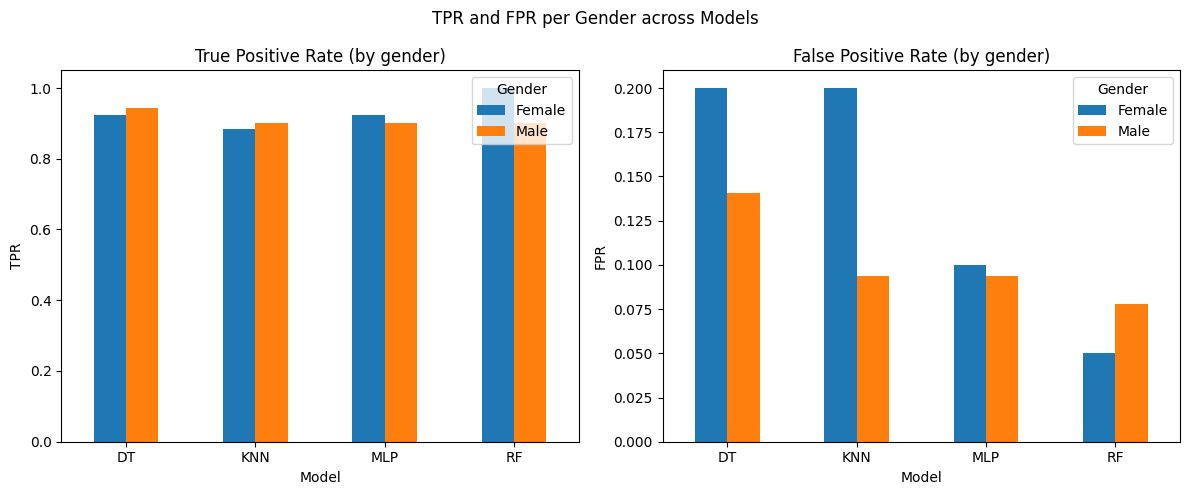

In [33]:
import matplotlib.pyplot as plt

# Collect per-model, per-gender TPR/FPR from your stored MetricFrame tables
rows = []
for model, res in fairlearn_results.items():
    mf = res["MetricFrame"]              
    for g in mf.index:                    
        rows.append({"Model": model, "Gender": g, "TPR": mf.loc[g, "tpr"], "FPR": mf.loc[g, "fpr"]})
df_plot = pd.DataFrame(rows)

# Make gender labels 
df_plot["Gender"] = df_plot["Gender"].map({0: "Female", 1: "Male"}).fillna(df_plot["Gender"])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# TPR bar plot
df_plot.pivot(index="Model", columns="Gender", values="TPR").plot.bar(ax=axes[0], rot=0, legend=True)
axes[0].set_title("True Positive Rate (by gender)")
axes[0].set_ylabel("TPR")

# FPR bar plot
df_plot.pivot(index="Model", columns="Gender", values="FPR").plot.bar(ax=axes[1], rot=0, legend=True)
axes[1].set_title("False Positive Rate (by gender)")
axes[1].set_ylabel("FPR")

plt.suptitle("TPR and FPR per Gender across Models")
plt.tight_layout()
plt.show()

## TPR and FPR per Gender Across Models

The plots compare **True Positive Rate (TPR)** and **False Positive Rate (FPR)** for females and males across models.

- **DT**: Balanced TPR across genders, but females face a much higher FPR (~0.20 vs. 0.14).  
- **KNN**: Slight male advantage in TPR, with females showing a much higher FPR (~0.20 vs. 0.09).  
- **MLP**: Nearly equal TPR and FPR across genders, indicating good fairness.  
- **RF**: Favors females in TPR (perfect recall), but males have a lower FPR (~0.08 vs. 0.05).  

**Overall**:  
- **MLP** is the most balanced model.  
- **RF** shows trade-offs (female advantage in recall, male advantage in FPR).  
- **DT and KNN** disadvantage females through consistently higher false positive rates.


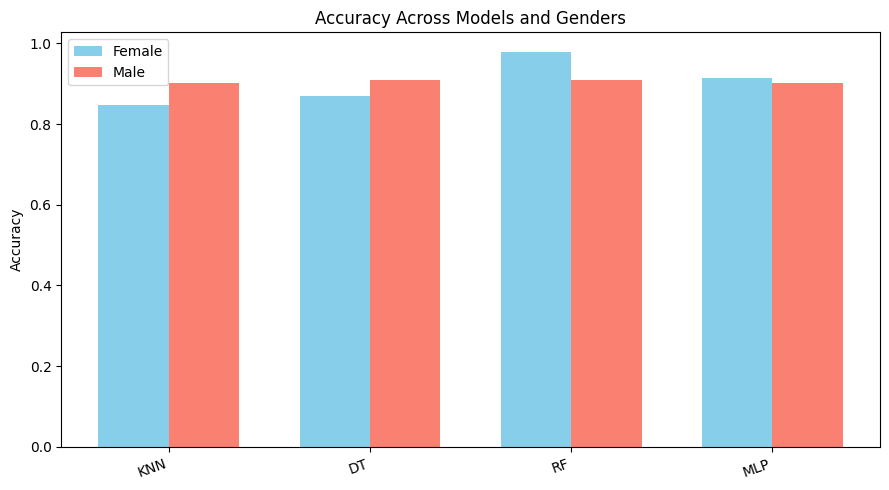

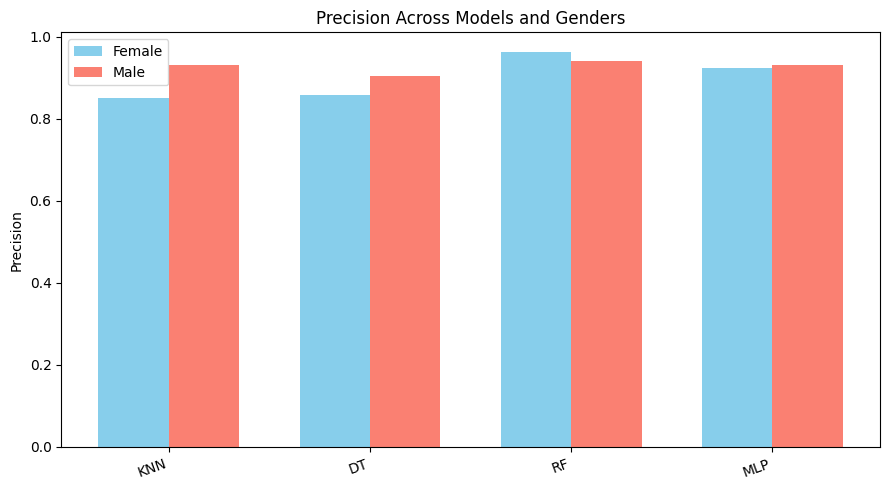

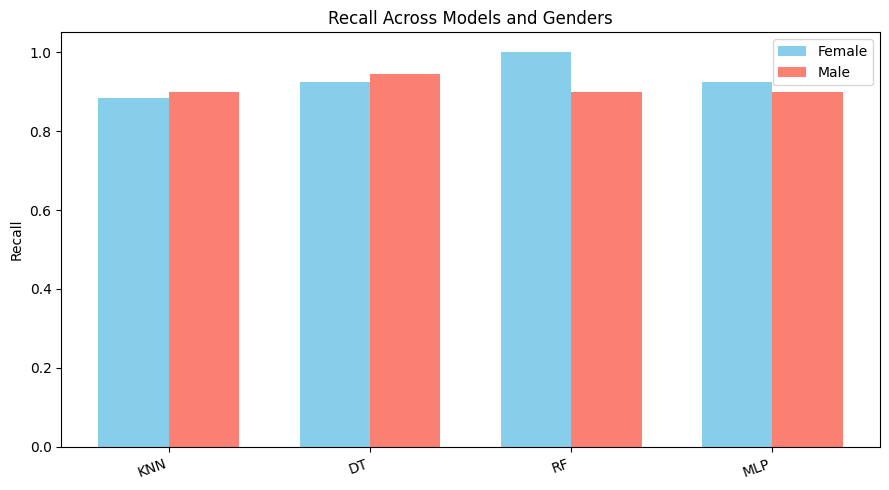

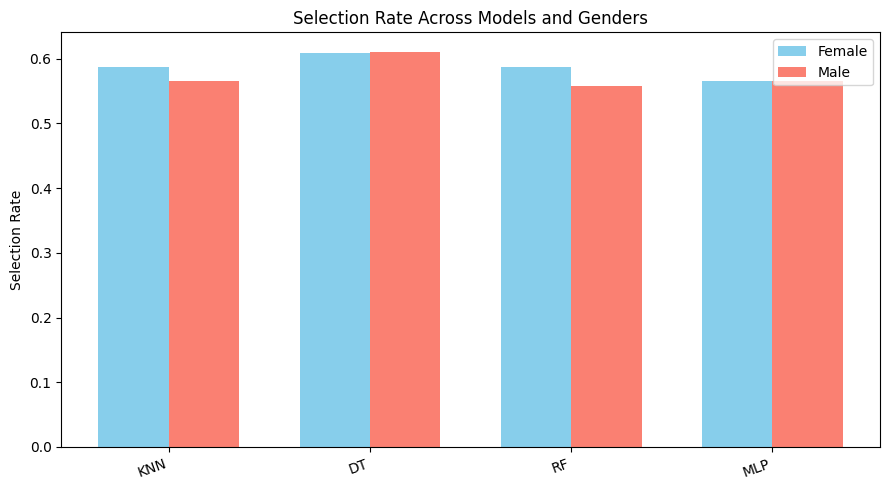

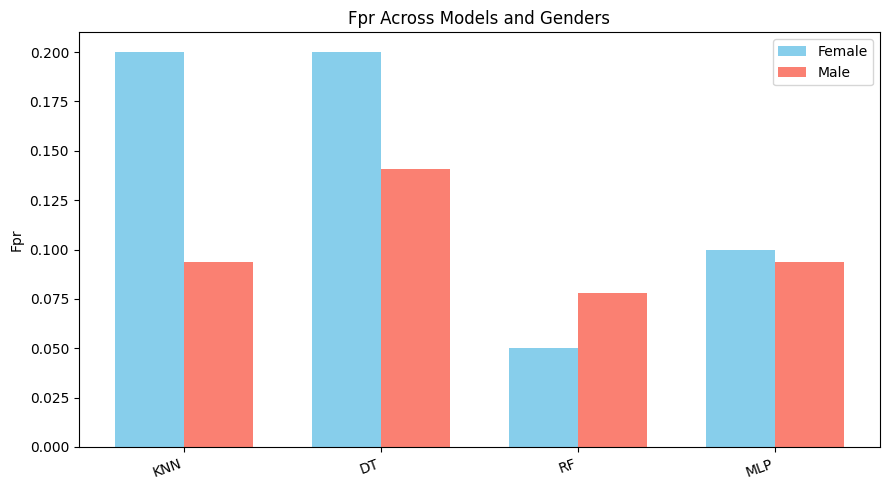

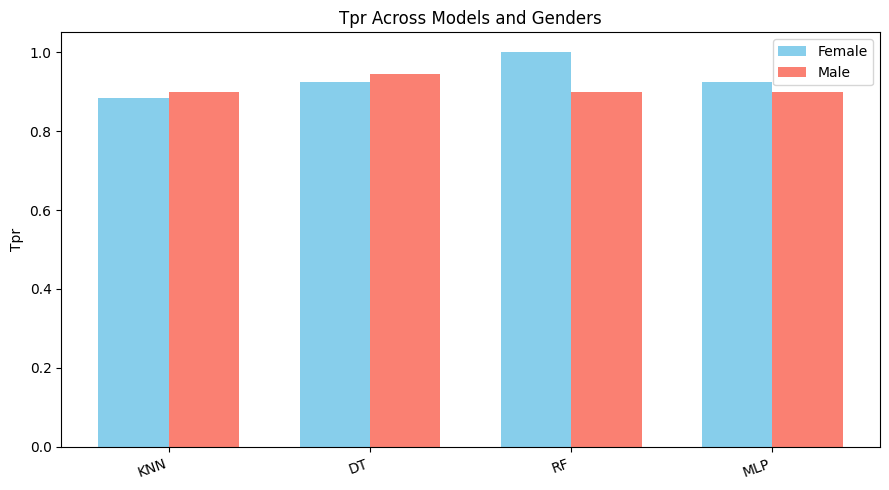

In [34]:
# visualize the comparison
import matplotlib.pyplot as plt
import numpy as np

# Data
models = list(fairlearn_results.keys())

# Shorter labels for better visualization
short_labels = [
    "KNN",
    "DT",
    "RF",
    "MLP",
]

metrics = ['accuracy', 'precision', 'recall', 'selection_rate', 'fpr', 'tpr']
genders = [0, 1]
gender_labels = {0: 'Female', 1: 'Male'}
colors = ['skyblue', 'salmon']

for metric in metrics:
    plt.figure(figsize=(9, 5))
    for idx, gender in enumerate(genders):
        values = [
            fairlearn_results[model]["MetricFrame"].loc[gender][metric]
            for model in models
        ]
        positions = np.arange(len(models)) + idx * 0.35
        plt.bar(positions, values, width=0.35, label=gender_labels[gender], color=colors[idx])
    
    plt.xticks(np.arange(len(models)) + 0.35 / 2, short_labels, rotation=20, ha='right')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f"{metric.replace('_', ' ').title()} Across Models and Genders")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Gender-Specific Performance Across Models

The plots compare **accuracy, precision, recall, selection rate, FPR, and TPR** for females and males across all four models.

---

### Accuracy
- **RF**: Highest female accuracy (0.98), but lower for males (0.91).  
- **KNN & DT**: Males outperform females.  
- **MLP**: Nearly balanced accuracy.  

### Precision
- **Males** generally achieve slightly higher precision across all models except RF, where females are stronger.  
- **MLP**: Very small gender gap in precision.  

### Recall
- **RF**: Females benefit from **perfect recall (1.0)**, while males are lower (0.90).  
- **KNN & DT**: Males achieve slightly higher recall.  
- **MLP**: Nearly equal recall across genders.  

### Selection Rate
- Almost equal across genders in all models.  
- **DT** shows the closest parity, while KNN and RF show small female advantages.  

### False Positive Rate (FPR)
- **KNN & DT**: Females have a much higher FPR (~0.20 vs. ~0.09–0.14).  
- **RF**: Males show a higher FPR (0.08 vs. 0.05).  
- **MLP**: Nearly identical FPRs (~0.10 each).  

### True Positive Rate (TPR)
- **RF**: Strong female advantage (1.0 vs. 0.90).  
- **DT & KNN**: Males slightly higher.  
- **MLP**: Very small gap, close to parity.  

---

### Overall Interpretation
- **MLP**: The most **balanced model**, with minimal gender gaps across all metrics.  
- **RF**: Strongly **favors females**, granting them perfect recall and higher accuracy, but disadvantages males with more missed positives.  
- **KNN & DT**: **Favor males**, especially in recall and error rates, while females face higher false positive rates.  

**Conclusion**:  
The training imbalance (75% females, 25% males) influenced outcomes:  
- RF overfit to females (majority group).  
- KNN and DT generalized better to males, disadvantaging the majority group.  
- MLP achieved the **fairest balance**, minimizing bias despite the imbalance.  
